## Import Libraries

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from efficient_apriori import apriori #from PyPi
from fpgrowth_py import fpgrowth #from PyPi
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Custom functions

In [2]:
def getWeatherStation(x):
    if x == 'MANHATTAN':
        return 'USW00094728'
    elif x == 'BRONX' or x == 'QUEENS':
        return 'USW00014732'
    elif x == 'STATEN ISLAND' or x == 'BROOKLYN':
        return 'USW00094789'
    else:
        return 'UNKNOWN'

def getTimeOfDay(x):
    if ((x >= 4) & (x <= 8 )):
        return 'Early Morning'
    elif ((x > 8) & (x < 12 )):
        return 'Morning'
    elif ((x >= 12) & (x <= 15 )):
        return 'Early After Noon'
    elif ((x > 15) & (x < 17 )):
        return 'Late After Noon'
    elif ((x >= 17) & (x < 20 )):
        return 'Evening'
    elif ((x >= 20) & (x <= 24 )):
        return 'Night'
    else:
        return 'Late Night'

def runApriori(dataSet,min_sup,min_conf):
    itemsets, rules = apriori(dataSet, min_support=min_sup, min_confidence=min_conf)
    return itemsets,rules

## Read data from data sources

In [3]:
# Get daily climate data for all 3 weather stations of nyc
header_list = ['station name', 'date','record type','value','M-flag','Q-flag','S-flag','obs-time']
df_read_climatedata_JFK = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00094789.csv.gz",header=None,names=header_list,usecols=['station name','date','record type','value'])
df_read_climatedata_laguardia = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00014732.csv.gz",header=None,names=header_list,usecols=['station name','date','record type','value'])
df_read_climatedata_centralpark = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00094728.csv.gz",header=None,names=header_list, usecols=['station name','date','record type','value'])

#USW00094789 - NY JFK Station
#USW00014732 - NY Laguardia
#USW00094728 - NY Central Park

# Read crash incidents data
crashEvents = pd.read_csv('/Users/abhis/Documents/MSU/Project/data.csv',parse_dates=['crash_date'],dtype={'longitude':np.float64, 'latitude':np.float64})

## PreProcess data

In [4]:
# Convert string date column to datetime for climate data dataframes
df_read_climatedata_JFK['date'] = pd.to_datetime(df_read_climatedata_JFK['date'],format="%Y%m%d").dt.strftime('%Y-%m-%d')
df_read_climatedata_laguardia['date'] = pd.to_datetime(df_read_climatedata_laguardia['date'],format="%Y%m%d").dt.strftime('%Y-%m-%d')
df_read_climatedata_centralpark['date'] = pd.to_datetime(df_read_climatedata_centralpark['date'],format="%Y%m%d").dt.strftime('%Y-%m-%d')
crashEvents['crash_date'] = pd.to_datetime(crashEvents['crash_date'],format="%Y-%m-%d")

# Rename column
crashEvents.rename(columns={'crash_date': 'date'}, inplace=True)


In [5]:
#Filter the data for last 5 years - 2017, 2018, 2019, 2020, 2021
startdate = pd.to_datetime("2017-01-01").date()
df_read_climatedata_JFK = df_read_climatedata_JFK[(df_read_climatedata_JFK['date'] >= '2017-01-01')]
df_read_climatedata_laguardia = df_read_climatedata_laguardia[(df_read_climatedata_laguardia['date'] >= '2017-01-01')]
df_read_climatedata_centralpark = df_read_climatedata_centralpark[(df_read_climatedata_centralpark['date'] >= '2017-01-01')]

crashEvents = crashEvents[(crashEvents['date'] >= '2017-01-01')]


In [6]:
# Reset index for all data frames
df_read_climatedata_JFK.reset_index(drop=True,inplace=True)
df_read_climatedata_laguardia.reset_index(drop=True,inplace=True)
df_read_climatedata_centralpark.reset_index(drop=True,inplace=True)
crashEvents.reset_index(drop=True,inplace=True)

In [7]:
# Extract day and month from the crash event date column
crashEvents['day'] = crashEvents['date'].dt.strftime('%A')
crashEvents['month'] = crashEvents['date'].dt.month

In [8]:
# Weather station to borough mapping - Manhattan -> Central Park WS, Bronx and Queen -> Laguardia WS, Staten Island and Brooklyn -> JFK

crashEvents['stationCode'] = crashEvents['borough'].apply(lambda x: getWeatherStation(x) )
crashEvents['timeOfDay'] = crashEvents['crash_time'].apply(lambda x: getTimeOfDay(int(x[:2].replace(":",''))) )

In [9]:
# Pivot the weather station dataframes and create news ones to be used
df_climatedata_JFK = df_read_climatedata_JFK.pivot(index='date',columns='record type',values='value')
df_climatedata_laguardia = df_read_climatedata_laguardia.pivot(index='date',columns='record type',values='value')
df_climatedata_centralpark = df_read_climatedata_centralpark.pivot(index='date',columns='record type',values='value')

In [10]:
# Assign station codes
df_climatedata_JFK['stationCode'] = 'USW00094789'
df_climatedata_laguardia['stationCode'] = 'USW00014732'
df_climatedata_centralpark['stationCode'] = 'USW00094728'

In [11]:
# reset indexes for the dataframes
df_climatedata_JFK.reset_index(inplace=True)
df_climatedata_laguardia.reset_index(inplace=True)
df_climatedata_centralpark.reset_index(inplace=True)

In [12]:
# drop not required columns from crash events table to reduce the dimensionality
crashEvents.drop(columns=['latitude','longitude','contributing_factor_vehicle_1','vehicle_type_code1'],inplace=True)

df_climatedata_JFK = df_climatedata_JFK[["date","stationCode","PRCP","SNOW","TMAX","TMIN"]]
df_climatedata_laguardia = df_climatedata_laguardia[["date","stationCode","PRCP","SNOW","TMAX","TMIN"]]
df_climatedata_centralpark = df_climatedata_centralpark[["date","stationCode","PRCP","SNOW","TMAX","TMIN"]]


In [13]:
# Merge all the dataframes into one
crashEvents['date']=crashEvents.date.astype('datetime64[ns]')
df_climatedata_JFK['date'] = df_climatedata_JFK.date.astype('datetime64[ns]')
df_climatedata_laguardia['date'] = df_climatedata_laguardia.date.astype('datetime64[ns]')
df_climatedata_centralpark['date'] = df_climatedata_centralpark.date.astype('datetime64[ns]')

allClimateData = pd.concat([df_climatedata_JFK,df_climatedata_laguardia,df_climatedata_centralpark])

allData = pd.merge(crashEvents,allClimateData,how='left',on=['date','stationCode'])

# Fill NaN with zeros
allData = allData.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('UNKNOWN'))

In [14]:
# Prepare final dataframe - objective is to further reduce the dimensionality
#df = allData.groupby(by=['date','day','timeOfDay','month','borough','postalCode','PRCP','SNOW','TMAX','TMIN'], as_index=False).agg({'number_of_persons_injured':'sum','number_of_persons_killed':'sum','number_of_pedestrians_injured':'sum','number_of_pedestrians_killed':'sum','number_of_cyclist_injured':'sum','number_of_cyclist_killed':'sum','number_of_motorist_injured':'sum','number_of_motorist_killed':'sum'})
df = allData.groupby(by=['date','day','timeOfDay','month','borough','postalCode','PRCP','SNOW','TMAX','TMIN'], as_index=False).agg({'number_of_persons_injured':'sum','number_of_persons_killed':'sum'})

df['lowerLimit_injured'] = df['number_of_persons_injured'] - 2
df['higherLimit_injured'] = df['number_of_persons_injured'] + 2

df['lowerLimit_killed'] = df['number_of_persons_killed'] - 2
df['higherLimit_killed'] = df['number_of_persons_killed'] + 2

In [15]:
# Encode 'day' and 'timeOfDay' with OrdinalEncoder
ordinal_encoder1 = OrdinalEncoder()
ordinal_encoder2 = OrdinalEncoder()
ordinal_encoder3 = OrdinalEncoder()

day_cat = df[['day']]
timeOfDay_cat = df[['timeOfDay']]
borough_cat = df[['borough']]

day_encoded = ordinal_encoder1.fit_transform(day_cat)
timeOfDay_encoded = ordinal_encoder2.fit_transform(timeOfDay_cat)
borough_encoded = ordinal_encoder3.fit_transform(borough_cat)

df['day_encoded'] = day_encoded
df['timeOfDay_encoded'] = timeOfDay_encoded
df['borough_encoded'] = borough_encoded


In [16]:
#df[df['number_of_pedestrians_killed']>0]['timeOfDay'].value_counts().plot(kind='bar')
#df.to_csv('/Users/abhis/Documents/MSU/Project/check_ml_data.csv',float_format='%.15f',index=False)
df

,date,day,timeOfDay,month,borough,postalCode,PRCP,SNOW,TMAX,TMIN,number_of_persons_injured,number_of_persons_killed,lowerLimit_injured,higherLimit_injured,lowerLimit_killed,higherLimit_killed,day_encoded,timeOfDay_encoded,borough_encoded
0,2017-01-01,Sunday,Early After Noon,1,BRONX,10451,0.0,0.0,94.0,39.0,0.0,0.0,-2.0,2.0,-2.0,2.0,3.0,0.0,0.0
1,2017-01-01,Sunday,Early After Noon,1,BRONX,10452,0.0,0.0,94.0,39.0,0.0,0.0,-2.0,2.0,-2.0,2.0,3.0,0.0,0.0
2,2017-01-01,Sunday,Early After Noon,1,BRONX,10455,0.0,0.0,94.0,39.0,0.0,0.0,-2.0,2.0,-2.0,2.0,3.0,0.0,0.0
3,2017-01-01,Sunday,Early After Noon,1,BRONX,10458,0.0,0.0,94.0,39.0,0.0,0.0,-2.0,2.0,-2.0,2.0,3.0,0.0,0.0
4,2017-01-01,Sunday,Early After Noon,1,BRONX,10466,0.0,0.0,94.0,39.0,1.0,0.0,-1.0,3.0,-2.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619675,2021-12-03,Friday,Morning,12,QUEENS,11421,0.0,0.0,100.0,44.0,1.0,0.0,-1.0,3.0,-2.0,2.0,0.0,5.0,3.0
619676,2021-12-03,Friday,Morning,12,QUEENS,11422,0.0,0.0,100.0,44.0,2.0,0.0,0.0,4.0,-2.0,2.0,0.0,5.0,3.0
619677,2021-12-03,Friday,Morning,12,QUEENS,11435,0.0,0.0,100.0,44.0,0.0,0.0,-2.0,2.0,-2.0,2.0,0.0,5.0,3.0
619678,2021-12-03,Friday,Morning,12,QUEENS,11691,0.0,0.0,100.0,44.0,0.0,0.0,-2.0,2.0,-2.0,2.0,0.0,5.0,3.0


## Correlation analysis

In [17]:
corr_matrix = df[(df['number_of_persons_killed']>0) | (df['number_of_persons_injured']>0)][["date","month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN","number_of_persons_injured","number_of_persons_killed"]].corr()
#corr_matrix = df[["date","month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN","number_of_persons_injured","number_of_persons_killed","number_of_pedestrians_injured","number_of_pedestrians_killed","number_of_cyclist_injured","number_of_cyclist_killed","number_of_motorist_injured","number_of_motorist_killed"]].corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)


,month,day_encoded,timeOfDay_encoded,borough_encoded,postalCode,PRCP,SNOW,TMAX,TMIN,number_of_persons_injured,number_of_persons_killed
month,1.00,-0.00,0.00,0.00,-0.00,0.03,-0.07,0.25,0.29,0.00,0.00
day_encoded,-0.00,1.00,-0.01,0.00,-0.00,-0.03,0.01,0.01,0.02,-0.01,-0.00
timeOfDay_encoded,0.00,-0.01,1.00,-0.01,-0.01,0.01,-0.00,0.02,0.02,0.02,0.01
borough_encoded,0.00,0.00,-0.01,1.00,0.20,0.00,0.00,-0.00,0.00,-0.03,0.00
postalCode,-0.00,-0.00,-0.01,0.20,1.00,-0.01,-0.01,-0.00,-0.01,0.05,-0.00
PRCP,0.03,-0.03,0.01,0.00,-0.01,1.00,0.12,-0.01,0.03,-0.01,0.00
SNOW,-0.07,0.01,-0.00,0.00,-0.01,0.12,1.00,-0.17,-0.16,-0.00,-0.00
TMAX,0.25,0.01,0.02,-0.00,-0.00,-0.01,-0.17,1.00,0.96,0.02,0.00
TMIN,0.29,0.02,0.02,0.00,-0.01,0.03,-0.16,0.96,1.00,0.02,0.00
number_of_persons_injured,0.00,-0.01,0.02,-0.03,0.05,-0.01,-0.00,0.02,0.02,1.00,-0.05


## Data Mining

In [18]:
# Prepare dataframe for - persons killed 
df_for_association_mining_personsKilled = df[(df['number_of_persons_killed']>0)][["timeOfDay","day","month","borough","number_of_persons_killed"]]

df_for_association_mining_personsKilled['month'] = df_for_association_mining_personsKilled['month'].astype("str")
#df_for_association_mining_personsKilled['postalCode'] = df_for_association_mining_personsKilled['postalCode'].astype("str")
df_for_association_mining_personsKilled['number_of_persons_killed'] = df_for_association_mining_personsKilled['number_of_persons_killed'].astype("str")
#df_for_association_mining_personsKilled['PRCP'] = df_for_association_mining_personsKilled['PRCP'].astype("str")
# Convert dataframe to list of tuples
transactions_from_df_1 = [tuple(row) for row in df_for_association_mining_personsKilled.values.tolist()]

In [19]:
# Prepare dataframe for - persons injured 
df_for_association_mining_personsInjured = df[(df['number_of_persons_injured']>0)][["timeOfDay","day","month","borough","number_of_persons_injured"]]

df_for_association_mining_personsInjured['month'] = df_for_association_mining_personsInjured['month'].astype("str")
#df_for_association_mining_personsInjured['postalCode'] = df_for_association_mining_personsInjured['postalCode'].astype("str")
df_for_association_mining_personsInjured['number_of_persons_injured'] = df_for_association_mining_personsInjured['number_of_persons_injured'].astype("str")
#df_for_association_mining_personsInjured['PRCP'] = df_for_association_mining_personsInjured['PRCP'].astype("str")
# Convert dataframe to list of tuples
transactions_from_df_2 = [tuple(row) for row in df_for_association_mining_personsInjured.values.tolist()]

### Association rule mining - Using Apriori Algorithm

In [20]:
# Run apriori to find association rules for persons killed
itemsets, rules = runApriori(transactions_from_df_1, min_sup=0.20, min_conf=0.90)
print(rules)

[{BROOKLYN} -> {1.0}, {Night} -> {1.0}, {QUEENS} -> {1.0}]


In [21]:
# Run apriori to find association rules for persons injured
itemsets, rules = runApriori(transactions_from_df_2, min_sup=0.20, min_conf=0.60)
print(rules)

[{BROOKLYN} -> {1.0}, {QUEENS} -> {1.0}]


### Association rule mining - Using FP growth algorithm

In [22]:
freqItemSet, rules = fpgrowth(transactions_from_df_1, minSupRatio=0.2, minConf=0.5)
print(rules)


[[{'Night'}, {'1.0'}, 0.9777777777777777], [{'QUEENS'}, {'1.0'}, 0.9537037037037037], [{'BROOKLYN'}, {'1.0'}, 0.9792899408284024]]


In [23]:
freqItemSet, rules = fpgrowth(transactions_from_df_2, minSupRatio=0.2, minConf=0.5)
print(rules)

[[{'QUEENS'}, {'1.0'}, 0.7128847460918536], [{'BROOKLYN'}, {'1.0'}, 0.704885520514228]]


## Unsupervised Learning

### Clustering - K-Means

In [24]:
k= 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(df[["number_of_persons_injured","day_encoded"]])

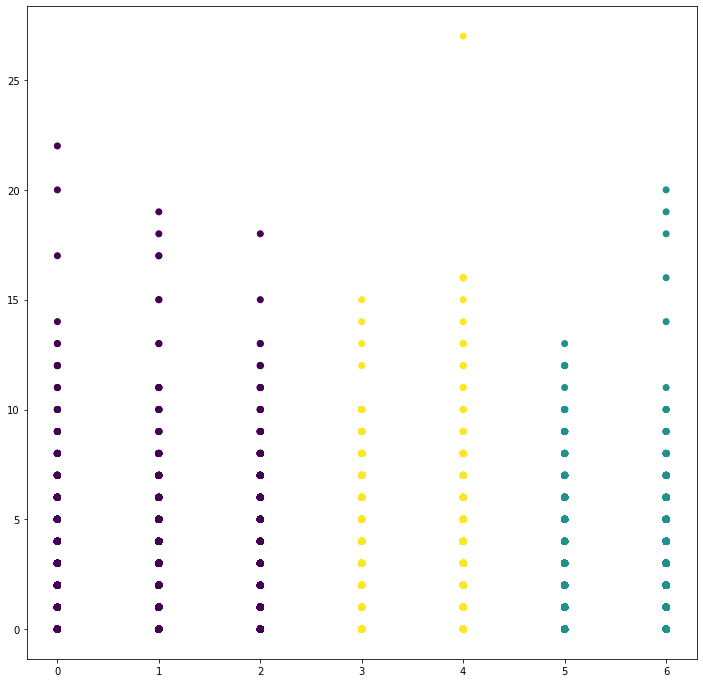

In [25]:
plt.figure(figsize=(12, 12))
plt.scatter(df["day_encoded"], df["number_of_persons_injured"], c=y_pred)
plt.show()

In [26]:
"""
# Street data - use it later
df_rd = pd.read_json('https://data.cityofnewyork.us/resource/7tqx-n33y.json?$$app_token=o4zuGaRztD7CZUutUDTALPc61&$where=within_circle(the_geom,40.8434639999999,-73.8359999999999,100)')
df_rd[:1]
# STATUS, BIKE_LANE, BOROCODE, ST_WIDTH, TRAFDIR, RW_TYPE, SNOW_PRI, R_ZIP, L_ZIP
"""

"\n# Street data - use it later\ndf_rd = pd.read_json('https://data.cityofnewyork.us/resource/7tqx-n33y.json?$$app_token=o4zuGaRztD7CZUutUDTALPc61&$where=within_circle(the_geom,40.8434639999999,-73.8359999999999,100)')\ndf_rd[:1]\n# STATUS, BIKE_LANE, BOROCODE, ST_WIDTH, TRAFDIR, RW_TYPE, SNOW_PRI, R_ZIP, L_ZIP\n"

## Predictions

### Prepare data set for models

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
#import xgboost
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Split data to generate the test set (to be included for validation as well)
X_inj = df[(df['date']<'2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
y_inj = df[(df['date']<'2021-04-01')][["number_of_persons_injured"]]

X_kill = df[(df['date']<'2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
y_kill = df[(df['date']<'2021-04-01')][["number_of_persons_killed"]]

new_df = df.groupby(by=["date","month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"],as_index=False).size()
X_crash = new_df[(new_df['date']<'2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
y_crash = new_df[(new_df['date']<'2021-04-01')][["size"]]

In [29]:
# Check model on unseen data for beyond 2021 April
X_inj_unseen = df[(df['date']>='2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
X_kill_unseen = df[(df['date']>='2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
y_inj_unseen = df[(df['date']>='2021-04-01')][["number_of_persons_injured"]]
y_kill_unseen = df[(df['date']>='2021-04-01')][["number_of_persons_killed"]]
X_crash_unseen = new_df[(new_df['date']>='2021-04-01')][["month","day_encoded","timeOfDay_encoded","borough_encoded","postalCode","PRCP","SNOW","TMAX","TMIN"]]
y_crash_unseen = new_df[(new_df['date']>='2021-04-01')][["size"]]

### Prepare training and validation data set for models

In [30]:
# For persons injured
X_train_inj,X_test_inj,y_train_inj,y_test_inj = train_test_split(X_inj,y_inj,test_size=0.20,random_state=18)

# For persons killed
X_train_kill,X_test_kill,y_train_kill,y_test_kill = train_test_split(X_kill,y_kill,test_size=0.20,random_state=18)

# For crash
X_train_crash,X_test_crash,y_train_crash,y_test_crash = train_test_split(X_crash,y_crash,test_size=0.20,random_state=18)

### Gradient Boosting Regression

In [31]:

# Create models
model_inj = GradientBoostingRegressor(loss="squared_error",learning_rate=0.1,n_estimators=200)
model_kil = GradientBoostingRegressor(loss="squared_error",learning_rate=0.1,n_estimators=200)
model_crash = GradientBoostingRegressor(loss="squared_error",learning_rate=0.1,n_estimators=200)

In [32]:
# Train and Fit models
#model_inj.fit(X_train_inj, y_train_inj)
#model_kil.fit(X_train_kill, y_train_kill)
scores_train_inj = cross_val_score(model_inj,X_train_inj, y_train_inj,scoring='neg_mean_squared_error',cv=10)
scores_train_kill = cross_val_score(model_kil,X_train_kill, y_train_kill,scoring='neg_mean_squared_error',cv=10)
scores_train_crash = cross_val_score(model_crash,X_train_crash, y_train_crash,scoring='neg_mean_squared_error',cv=10)

print("Mean RMSE for injuries ",(np.sqrt(-scores_train_inj)).mean())
print("Standard Deviation for injuries ",(np.sqrt(-scores_train_inj)).std())

print("Mean RMSE for kills ",(np.sqrt(-scores_train_kill)).mean())
print("Standard Deviation for kills ",(np.sqrt(-scores_train_kill)).std())

print("Mean RMSE for crash ",(np.sqrt(-scores_train_crash)).mean())
print("Standard Deviation for crash ",(np.sqrt(-scores_train_crash)).std())



Mean RMSE for injuries  0.8049341215696344
Standard Deviation for injuries  0.006040316169155018
Mean RMSE for kills  0.04419121581957643
Standard Deviation for kills  0.006089976098008421
Mean RMSE for crash  0.0
Standard Deviation for crash  0.0


In [33]:
model_inj.fit(X_train_inj, y_train_inj)
model_kil.fit(X_train_kill, y_train_kill)
model_crash.fit(X_train_crash, y_train_crash)

# Record actual values on test set
#predictions = pd.DataFrame(y_test_inj)
predictions = pd.concat([y_test_inj,y_test_kill],axis=1)
predictions_crash = pd.DataFrame(y_test_crash)
# Predict
predictions['pred_inj'] = model_inj.predict(X_test_inj)
predictions['pred_kil'] = model_kil.predict(X_test_kill)
predictions_crash['pred_crash'] = model_crash.predict(X_test_crash)

In [34]:
predictions['number_of_persons_injured'] = predictions['number_of_persons_injured'].round().astype("int")
predictions['pred_inj'] = predictions['pred_inj'].round().astype("int")

predictions['number_of_persons_killed'] = predictions['number_of_persons_killed'].round().astype("int")
predictions['pred_kil'] = predictions['pred_kil'].round().astype("int")

predictions_crash['size'] = predictions_crash['size'].round().astype("int")
predictions_crash['pred_crash'] = predictions_crash['pred_crash'].round().astype("int")

print("MAE for Injuries - ",metrics.mean_absolute_error(predictions['number_of_persons_injured'],predictions['pred_inj']))
print("RMSE for Injuries - ", metrics.mean_squared_error(predictions['number_of_persons_injured'],predictions['pred_inj']))

print("MAE for Kills - ",metrics.mean_absolute_error(predictions['number_of_persons_killed'],predictions['pred_kil']))
print("RMSE for Kills - ", metrics.mean_squared_error(predictions['number_of_persons_killed'],predictions['pred_kil']))

print("MAE for crash - ",metrics.mean_absolute_error(predictions_crash['size'],predictions_crash['pred_crash']))
print("RMSE for crash - ", metrics.mean_squared_error(predictions_crash['size'],predictions_crash['pred_crash']))

MAE for Injuries -  0.4297668430839651
RMSE for Injuries -  0.7808968674009441
MAE for Kills -  0.0017164926333857818
RMSE for Kills -  0.0018237734229723931
MAE for crash -  0.0
RMSE for crash -  0.0


In [35]:
# Record actual values on test set
predictions_unseen = pd.concat([y_inj_unseen,y_kill_unseen],axis=1)
predictions_unseen_crash = pd.DataFrame(y_crash_unseen)
# Predict
predictions_unseen['pred_inj'] = model_inj.predict(X_inj_unseen)
predictions_unseen['pred_kill'] = model_kil.predict(X_kill_unseen)
predictions_unseen_crash['pred_crash'] = model_kil.predict(X_crash_unseen)

In [36]:
predictions_unseen['number_of_persons_injured'] = predictions_unseen['number_of_persons_injured'].round().astype("int")
predictions_unseen['pred_inj'] = predictions_unseen['pred_inj'].round().astype("int")
predictions_unseen['number_of_persons_killed'] = predictions_unseen['number_of_persons_killed'].round().astype("int")
predictions_unseen['pred_kill'] = predictions_unseen['pred_kill'].round().astype("int")
predictions_unseen_crash['size'] = predictions_unseen_crash['size'].round().astype("int")
predictions_unseen_crash['pred_crash'] = predictions_unseen_crash['pred_crash'].round().astype("int")

print("MAE for Injuries - ",metrics.mean_absolute_error(predictions_unseen['number_of_persons_injured'],predictions_unseen['pred_inj']))
print("RMSE for Injuries - ", metrics.mean_squared_error(predictions_unseen['number_of_persons_injured'],predictions_unseen['pred_inj']))

print("MAE for Kills - ",metrics.mean_absolute_error(predictions_unseen['number_of_persons_killed'],predictions_unseen['pred_kill']))
print("RMSE for Kills - ", metrics.mean_squared_error(predictions_unseen['number_of_persons_killed'],predictions_unseen['pred_kill']))

print("MAE for crash - ",metrics.mean_absolute_error(predictions_unseen_crash['size'],predictions_unseen_crash['pred_crash']))
print("RMSE for crash - ", metrics.mean_squared_error(predictions_unseen_crash['size'],predictions_unseen_crash['pred_crash']))

MAE for Injuries -  0.593592715231788
RMSE for Injuries -  1.0665397350993377
MAE for Kills -  0.003112582781456954
RMSE for Kills -  0.003344370860927152
MAE for crash -  1.0
RMSE for crash -  1.0


In [37]:
# Calculate 90% confidence interval for errors
from scipy import stats

conf = 0.90

squared_errors = (predictions_unseen['number_of_persons_injured'] - predictions_unseen['pred_inj']) ** 2
np.sqrt( 
    stats.t.interval(conf,len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))
)

array([1.0202576 , 1.04506168])

### SVM Regression

In [38]:
# Create model

svm_reg_inj = LinearSVR(epsilon=0.5,)
svm_reg_kill = LinearSVR(epsilon=0.5)
svm_reg_crash = LinearSVR(epsilon=0.5)

In [39]:
scores_train_inj = cross_val_score(svm_reg_inj,X_train_inj, y_train_inj,scoring='neg_mean_squared_error',cv=10)
scores_train_kill = cross_val_score(svm_reg_kill,X_train_kill, y_train_kill,scoring='neg_mean_squared_error',cv=10)
scores_train_crash = cross_val_score(svm_reg_crash,X_train_crash, y_train_crash,scoring='neg_mean_squared_error',cv=10)

print("SVM - Mean RMSE for injuries ",(np.sqrt(-scores_train_inj)).mean())
print("SVM - Standard Deviation for injuries ",(np.sqrt(-scores_train_inj)).std())

print("SVM - Mean RMSE for kills ",(np.sqrt(-scores_train_kill)).mean())
print("SVM - Standard Deviation for kills ",(np.sqrt(-scores_train_kill)).std())

print("SVM - Mean RMSE for crash ",(np.sqrt(-scores_train_crash)).mean())
print("SVM - Standard Deviation for crash ",(np.sqrt(-scores_train_crash)).std())

SVM - Mean RMSE for injuries  0.8789321895324317
SVM - Standard Deviation for injuries  0.12761724561267238
SVM - Mean RMSE for kills  0.4756876763700727
SVM - Standard Deviation for kills  0.0007513832471543908
SVM - Mean RMSE for crash  0.19116011917772344
SVM - Standard Deviation for crash  0.00043414767236542523


In [40]:
svm_reg_inj.fit(X_train_inj, y_train_inj)
svm_reg_kill.fit(X_train_kill, y_train_kill)
svm_reg_crash.fit(X_train_crash, y_train_crash)

# Record actual values on test set
#predictions = pd.DataFrame(y_test_inj)
predictions_svm = pd.concat([y_test_inj,y_test_kill,y_test_crash],axis=1)
# Predict
predictions_svm['pred_inj'] = svm_reg_inj.predict(X_test_inj)
predictions_svm['pred_kil'] = svm_reg_kill.predict(X_test_kill)
predictions_svm['pred_crash'] = svm_reg_crash.predict(X_test_crash)

In [41]:
predictions_svm['number_of_persons_injured'] = predictions_svm['number_of_persons_injured'].round().astype("int")
predictions_svm['pred_inj'] = predictions_svm['pred_inj'].round().astype("int")

predictions_svm['number_of_persons_killed'] = predictions_svm['number_of_persons_killed'].round().astype("int")
predictions_svm['pred_kil'] = predictions_svm['pred_kil'].round().astype("int")

predictions_svm['size'] = predictions_svm['size'].round().astype("int")
predictions_svm['pred_crash'] = predictions_svm['pred_crash'].round().astype("int")

print("SVM - MAE for Injuries - ",metrics.mean_absolute_error(predictions_svm['number_of_persons_injured'],predictions_svm['pred_inj']))
print("SVM - RMSE for Injuries - ", metrics.mean_squared_error(predictions_svm['number_of_persons_injured'],predictions_svm['pred_inj']))

print("SVM - MAE for Kills - ",metrics.mean_absolute_error(predictions_svm['number_of_persons_killed'],predictions_svm['pred_kil']))
print("SVM - RMSE for Kills - ", metrics.mean_squared_error(predictions_svm['number_of_persons_killed'],predictions_svm['pred_kil']))

print("SVM - MAE for crash - ",metrics.mean_absolute_error(predictions_svm['size'],predictions_svm['pred_crash']))
print("SVM - RMSE for crash - ", metrics.mean_squared_error(predictions_svm['size'],predictions_svm['pred_crash']))

SVM - MAE for Injuries -  0.533140823916464
SVM - RMSE for Injuries -  0.8795862537548277
SVM - MAE for Kills -  0.05276426834501502
SVM - RMSE for Kills -  0.05285366900300386
SVM - MAE for crash -  0.0
SVM - RMSE for crash -  0.0


In [42]:
# Record actual values on test set
predictions_unseen_svm = pd.concat([y_inj_unseen,y_kill_unseen],axis=1)
# Predict
predictions_unseen_svm['pred_inj'] = svm_reg_inj.predict(X_inj_unseen)
predictions_unseen_svm['pred_kill'] = svm_reg_kill.predict(X_kill_unseen)

In [43]:
predictions_unseen_svm['number_of_persons_injured'] = predictions_unseen_svm['number_of_persons_injured'].round().astype("int")
predictions_unseen_svm['pred_inj'] = predictions_unseen_svm['pred_inj'].round().astype("int")
predictions_unseen_svm['number_of_persons_killed'] = predictions_unseen_svm['number_of_persons_killed'].round().astype("int")
predictions_unseen_svm['pred_kill'] = predictions_unseen_svm['pred_kill'].round().astype("int")

print("SVM - MAE for Injuries - ",metrics.mean_absolute_error(predictions_unseen_svm['number_of_persons_injured'],predictions_unseen_svm['pred_inj']))
print("SVM - RMSE for Injuries - ", metrics.mean_squared_error(predictions_unseen_svm['number_of_persons_injured'],predictions_unseen_svm['pred_inj']))

print("SVM - MAE for Kills - ",metrics.mean_absolute_error(predictions_unseen_svm['number_of_persons_killed'],predictions_unseen_svm['pred_kill']))
print("SVM - RMSE for Kills - ", metrics.mean_squared_error(predictions_unseen_svm['number_of_persons_killed'],predictions_unseen_svm['pred_kill']))

SVM - MAE for Injuries -  0.6520198675496689
SVM - RMSE for Injuries -  1.1295364238410597
SVM - MAE for Kills -  0.06220198675496689
SVM - RMSE for Kills -  0.06240066225165563


## Save Models

In [44]:

# saving the model 
import pickle 
pickle_out_inj = open("prediction_inj.pkl", mode = "wb") 
pickle.dump(model_inj, pickle_out_inj) 
pickle_out_inj.close()

pickle_out_kill = open("prediction_kill.pkl", mode = "wb") 
pickle.dump(model_kil, pickle_out_kill) 
pickle_out_kill.close()

pickle_out_crash = open("prediction_crash.pkl", mode = "wb") 
pickle.dump(model_crash, pickle_out_crash) 
pickle_out_crash.close()

encoder1 = open("encoder_day.pkl", mode = "wb") 
pickle.dump(ordinal_encoder1, encoder1) 
encoder1.close()

encoder2 = open("encoder_time_of_day.pkl", mode = "wb") 
pickle.dump(ordinal_encoder2, encoder2) 
encoder2.close()

encoder3 = open("encoder_borough.pkl", mode = "wb") 
pickle.dump(ordinal_encoder3, encoder3) 
encoder3.close()

#11367
# 11375
